# Drake Quad PID

In [1]:
import math
import pydot
import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import HTML, display, SVG
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    RobotDiagramBuilder,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    namedview,
)
from pydrake.examples import (
    AcrobotGeometry,
    AcrobotInput,
    AcrobotPlant,
    AcrobotState,
    QuadrotorGeometry,
    QuadrotorPlant,
    StabilizingLQRController,
)
from pydrake.solvers import MathematicalProgram, Solve
import os
from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer
from underactuated.scenarios import AddFloatingRpyJoint
from pydrake.multibody.tree import QuaternionFloatingJoint
if running_as_notebook:
    mpld3.enable_notebook()

/home/forge/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Visualization Server

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


## Make Multibody plant

We use the drake library to import our quad rotor without the propellers. This maintains its inertial properties and mass properties from the urdf file specified.

<img src="images/quad_arm.png" alt="Alt text" width="600"/>

Arm length measurement

In [6]:

def MakeMultibodyQuadrotor():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)
    #plant = builder.AddSystem(MultibodyPlant(0.0))
    #scene_graph = builder.AddSystem(SceneGraph())
    parser = Parser(plant)
    
    # Your relative path
    relative_path = "quad-v4/quad-v4.urdf"
    # Convert to an absolute path
    absolute_path = os.path.abspath(relative_path)
    
    # Use the absolute path here
    (model_instance,) = parser.AddModels(absolute_path)
    
    # Adding QuaternionFloatingJoint
    frame_on_parent = plant.world_frame()
    frame_on_child = plant.GetFrameByName("quad_v4", model_instance)
    plant.AddJoint(
        QuaternionFloatingJoint(
            name="BaseJoint",
            frame_on_parent=frame_on_parent,  # Corrected parameter name
            frame_on_child=frame_on_child,  # Corrected parameter name
            angular_damping=0.0,  # Optional, showing how to use it
            translational_damping=0.0  # Optional, showing how to use it
        )
    )
    plant.Finalize()

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat
    )

    body_index = plant.GetBodyByName("quad_v4").index()

    L = 0.395 #meters arm length
    #prop_offsets = [0.21507, 0.27856, 0.09495]
    prop_pos = {'x' : 0.21507, 'y' : 0.27856, 'z' : 0.09495}
    kF = 1.0 #0.77 #estimate thrust constant (thrust = kF * angularvelocity^2)
    kM = 1 #estimate torque constant (torque = kM * angularvelocity^2)

    """
    prop_info = [
        PropellerInfo(body_index, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(body_index, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    """

    prop_info = [
        PropellerInfo(body_index, RigidTransform([-prop_pos['x'], -prop_pos['y'], prop_pos['z']]), kF, kM), #CW
        PropellerInfo(body_index, RigidTransform([prop_pos['x'], -prop_pos['y'], prop_pos['z']]), kF, -kM), #CCW
        PropellerInfo(body_index, RigidTransform([prop_pos['x'], prop_pos['y'], prop_pos['z']]), kF, kM), #CW
        PropellerInfo(body_index, RigidTransform([-prop_pos['x'], prop_pos['y'], prop_pos['z']]), kF, -kM), #CCW
    ]
    propellers = builder.AddSystem(Propeller(prop_info))
    builder.Connect(
        propellers.get_output_port(),
        plant.get_applied_spatial_force_input_port(),
    )
    builder.Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )

    #quad_base = plant.GetModelInstanceByName("body")
    builder.ExportInput(propellers.get_command_input_port(), "u")
    builder.ExportOutput(plant.get_state_output_port(), "state")


    return builder.Build(), plant


In [7]:
quadrotor_system, quadrotor_plant = MakeMultibodyQuadrotor()

quadrotor_plant.set_name("quadrotor_base")

quadrotor_system.set_name("quadrotor_system")

### Viewing the plant diagram (no propeller dynamics)

Here we can view the different ports of our imported robot. There are two main types of ports, input ports, and output ports. Input ports are typically for input actuations, output ports are typically for state information such as position velocity and attitude.

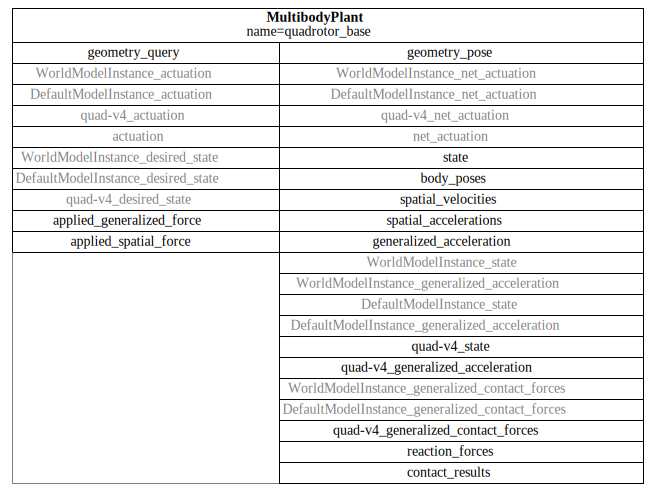

In [8]:
display(
    SVG(
        pydot.graph_from_dot_data(
            quadrotor_plant.GetGraphvizString(
                max_depth=3))[0].create_svg()))

### Printing information of plant (no propellers)

In [9]:
# First, ensure your MultibodyPlant 'mbp' is properly initialized and finalized
# as shown in your MakeMultibodyQuadrotor() function
from pydrake.multibody.tree import BodyIndex, JointIndex

# Information about states and elements
num_positions = quadrotor_plant.num_positions()
num_velocities = quadrotor_plant.num_velocities()
num_multibody_states = quadrotor_plant.num_multibody_states()
num_actuators = quadrotor_plant.num_actuators()  # Corrected from num_force_elements to num_actuators for clarity
num_force_elements = quadrotor_plant.num_force_elements()
num_bodies = quadrotor_plant.num_bodies()
num_joints = quadrotor_plant.num_joints()
num_model_instances = quadrotor_plant.num_model_instances()

# Printing the collected information
print(f"Number of position states: {num_positions}")
print(f"Number of velocity states: {num_velocities}")
print(f"Total number of multibody states: {num_multibody_states}")
print(f"Total number of force elements: {num_force_elements}")
print(f"Total number of bodies: {num_bodies}")
print(f"Number of joints: {num_joints}")
print(f"Number of model instances: {num_model_instances}")

# Additional useful information might include details about specific components, like joints and bodies.
# Here's how you could list the names of all bodies and joints in the MultibodyPlant:
print("\nList of all body names:")
for i in range(quadrotor_plant.num_bodies()):
    body = quadrotor_plant.get_body(BodyIndex(i))
    print(f"Body {i}: {body.name()}")
    print("---------------------------------------------")

print("\nList of all joint names:")
for i in range(quadrotor_plant.num_joints()):
    joint = quadrotor_plant.get_joint(JointIndex(i))
    print(f"Joint {i}: {joint.name()}")

print("\nPosition Names")
for name in quadrotor_plant.GetPositionNames():
    print(name)

print("\nVelocity Names")
for name in quadrotor_plant.GetVelocityNames():
    print(name)


print("\nState Names")
for name in quadrotor_plant.GetStateNames():
    print(name)

Number of position states: 7
Number of velocity states: 6
Total number of multibody states: 13
Total number of force elements: 1
Total number of bodies: 7
Number of joints: 6
Number of model instances: 3

List of all body names:
Body 0: world
---------------------------------------------
Body 1: CCW_Prop_3
---------------------------------------------
Body 2: CW_Prop1
---------------------------------------------
Body 3: Prop_4_CCW
---------------------------------------------
Body 4: quad_v4
---------------------------------------------
Body 5: quad_v4_Payload
---------------------------------------------
Body 6: quad_v4_Prop_2_CW
---------------------------------------------

List of all joint names:
Joint 0: CCW_Prop_4
Joint 1: Prop1_CW
Joint 2: Prop_3_CCW
Joint 3: base_link_Payload
Joint 4: base_link_Prop_2_CW
Joint 5: BaseJoint

Position Names
quad-v4_BaseJoint_qw
quad-v4_BaseJoint_qx
quad-v4_BaseJoint_qy
quad-v4_BaseJoint_qz
quad-v4_BaseJoint_x
quad-v4_BaseJoint_y
quad-v4_BaseJoi

### Viewing diagram of whole quadrotor system (with propellers and defined input output ports)

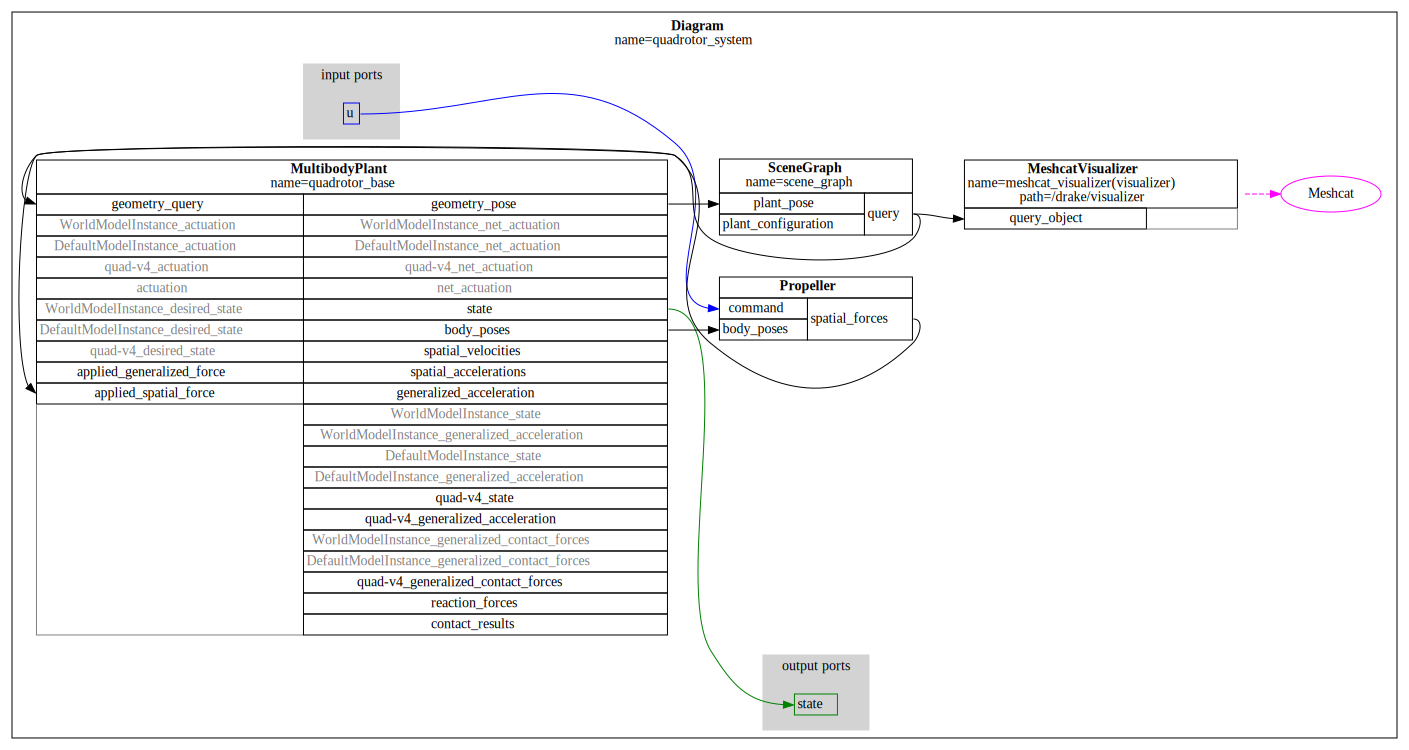

In [19]:
display(
    SVG(
        pydot.graph_from_dot_data(
            quadrotor_system.GetGraphvizString(
                max_depth=3))[0].create_svg()))

### Printing Input output port information

In [20]:
# Print information about input ports
print("Input Ports (Thrust commands)")
print(f"N input ports : {quadrotor_system.num_input_ports()}")
print(f"Actuation port size {quadrotor_system.get_input_port(0).size()} [u_1, u_2, u_3, u_4] for thrust produced by each prop")

# Print information about output ports
print("\nOutput Ports:")
print(f"N output ports : {quadrotor_system.num_input_ports()}")
print(f"State vector port size {quadrotor_system.get_output_port(0).size()} [x y z xdot ydot zdot pitch roll yaw dpitch droll dyaw] for state vector of position velocity attitude and angular rates")

Input Ports (Thrust commands)
N input ports : 1
Actuation port size 4 [u_1, u_2, u_3, u_4] for thrust produced by each prop

Output Ports:
N output ports : 1
State vector port size 12 [x y z xdot ydot zdot pitch roll yaw dpitch droll dyaw] for state vector of position velocity attitude and angular rates


## Simulate System

### Validate basic Behavior

We will simulate the system under moderate constant thrust equal between all motors. This should cause the drone to hover.

In [21]:
from pydrake.all import ConstantVectorSource

def SanityHoverCheck():
    quadrotor_diagram, quadrotor_plant = MakeMultibodyQuadrotor()
    # Create System Context
    context = quadrotor_diagram.CreateDefaultContext()
    
    # Calculate nominal input
    mass = quadrotor_plant.CalcTotalMass(quadrotor_plant.GetMyContextFromRoot(context))
    gravity = quadrotor_plant.gravity_field().gravity_vector()
    nominal_input = [(-mass * gravity[2]) / 4] * 4 #[CW, CW2, CCW, CCW2] CW - TOP RIGHT | CW2 - BOTTOM LEFT || CCW - TOP LEFT | CCW2 BOTTOM RIGHT
    #nominal_input = [0, 5, 0, 0]

    #Relative to the Camera (Camera is Top/Forward)
    #Front propellers
    #nominal_input[0] += 0.004 #Top Right CW
    #nominal_input[2] += 0.006 #Top Left CCW

    #Back propellers
    #nominal_input[1] += 0.0035 #Bottom left CW
    #nominal_input[3] += 0.003 #Bottom right CCW
    
    inertia = quadrotor_plant.CalcSpatialInertia(
        quadrotor_plant.GetMyContextFromRoot(context),
        quadrotor_plant.world_frame(),
        [quadrotor_plant.GetBodyByName("quad_v4").index()]
    )
    inertial_matrix = inertia.CopyToFullMatrix6()

    print("=============================")
    print(f"Quadrotor Plant Total Mass (kg) : {mass}")
    print(f"Gravity Vector [x y z] m/s^2 : {gravity}")
    print(f"Calculated Constant Hover Thrust Input [motor1 ... motor4] (N) : {nominal_input}")
    print("=============================")

    simulation_builder = DiagramBuilder()

    constant_actuation = simulation_builder.AddSystem(ConstantVectorSource(nominal_input))
    quadrotor = simulation_builder.AddSystem(quadrotor_diagram)
    simulation_builder.Connect(constant_actuation.get_output_port(0), quadrotor.get_input_port())

    simulation_diagram = simulation_builder.Build()

    return simulation_diagram


In [22]:
def initialize_simulation(diagram):
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)
    return simulator

def run_simulation(sim_time_step, finish_time, diagram):
    simulator = initialize_simulation(diagram)
    meshcat.StartRecording()
    simulator.AdvanceTo(finish_time)
    meshcat.PublishRecording()

In [23]:
sim_diagram = SanityHoverCheck()

run_simulation(sim_time_step = 0.1, finish_time=2, diagram=sim_diagram)

Quadrotor Plant Total Mass (kg) : 0.5970469
Gravity Vector [x y z] m/s^2 : [ 0.    0.   -9.81]
Calculated Constant Hover Thrust Input [motor1 ... motor4] (N) : [1.4642575222500003, 1.4642575222500003, 1.4642575222500003, 1.4642575222500003]


# Control (PX4)

We replicate PX4's control structure for position velocity attitude and attitude derivatives

![PX4](images/px4_control.png)

### Part 1 - Rate Controller

In [36]:
from pydrake.systems.framework import LeafSystem_
from pydrake.systems.scalar_conversion import TemplateSystem
from pydrake.autodiffutils import AutoDiffXd
from pydrake.symbolic import Expression
import numpy as np

@TemplateSystem.define("RateControl_")
def RateControl_(T):

    class Impl(LeafSystem_[T]):

        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            # Declare system ports
            self.DeclareVectorInputPort("rate", BasicVector_[T](3))
            self.DeclareVectorInputPort("rate_sp", BasicVector_[T](3))
            self.DeclareVectorInputPort("angular_accel", BasicVector_[T](3))
            self.DeclareVectorInputPort("dt", BasicVector_[T](1))
            self.DeclareVectorInputPort("landed", BasicVector_[T](1))

            self.DeclareVectorOutputPort("torque", BasicVector_[T](3), self.CalculateTorque)

            self.DeclareContinuousState(3)  # For the integral part of the control (rate_int)

            # Initialize PID gains and saturation flags
            self._gain_p = np.array([0.0, 0.0, 0.0], dtype=T)
            self._gain_i = np.array([0.0, 0.0, 0.0], dtype=T)
            self._gain_d = np.array([0.0, 0.0, 0.0], dtype=T)
            self._control_allocator_saturation_positive = np.array([False, False, False])
            self._control_allocator_saturation_negative = np.array([False, False, False])

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def CalculateTorque(self, context, output):
            rate = self.get_input_port(0).Eval(context)
            rate_sp = self.get_input_port(1).Eval(context)
            angular_accel = self.get_input_port(2).Eval(context)
            dt = self.get_input_port(3).Eval(context)[0]
            landed = self.get_input_port(4).Eval(context)[0] > 0.5

            rate_error = rate_sp - rate
            rate_int = context.get_continuous_state_vector().CopyToVector()

            if not landed:
                rate_int = self.update_integral(rate_error, dt, rate_int)

            torque = self._gain_p * rate_error + rate_int - self._gain_d * angular_accel
            output.SetFromVector(torque)

        def update_integral(self, rate_error, dt, rate_int):
            # Integral update logic, considering saturation
            updated_rate_int = rate_int  # Simplified for illustration
            return updated_rate_int

    return Impl


### Part 2 - Attitude Controller

In [37]:
from pydrake.all import LeafSystem_, BasicVector_, TemplateSystem, AutoDiffXd, Quaternion_, RigidTransform_
import numpy as np

@TemplateSystem.define("AttitudeControl_")
def AttitudeControl_(T):

    class Impl(LeafSystem_[T]):

        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)

            # Input ports
            self.current_attitude_port = self.DeclareVectorInputPort("current_attitude", BasicVector_[T](4))
            self.desired_attitude_port = self.DeclareVectorInputPort("desired_attitude", BasicVector_[T](4))
            self.yaw_rate_setpoint_port = self.DeclareVectorInputPort("yaw_rate_setpoint", BasicVector_[T](1))
            
            # Output ports
            self.DeclareVectorOutputPort("rate_setpoint", BasicVector_[T](3), self.CalculateRateSetpoint)
            
            # Internal parameters
            self.proportional_gain = np.array([1.0, 1.0, 1.0], dtype=np.object)  # Default gains
            self.yaw_weight = T(1.0)
            self.rate_limit = np.array([np.inf, np.inf, np.inf], dtype=np.object)  # Default rate limits
            self.yawspeed_setpoint = T(0)

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def set_proportional_gain(self, proportional_gain, yaw_weight):
            self.proportional_gain = np.array(proportional_gain, dtype=np.object)
            self.yaw_weight = np.clip(yaw_weight, 0.0, 1.0)
            if self.yaw_weight > 1e-4:
                self.proportional_gain[2] /= self.yaw_weight

        def set_rate_limit(self, rate_limit):
            self.rate_limit = np.array(rate_limit, dtype=np.object)

        def CalculateRateSetpoint(self, context, output):
            current_attitude = Quaternion_[T](self.current_attitude_port.Eval(context))
            desired_attitude = Quaternion_[T](self.desired_attitude_port.Eval(context))
            self.yawspeed_setpoint = self.yaw_rate_setpoint_port.Eval(context)[0]

            # Quaternion operations to compute the attitude error and rate setpoint
            rate_setpoint = self.calculate_rate_setpoint(current_attitude, desired_attitude, self.yawspeed_setpoint)

            # Limit rates
            for i in range(3):
                rate_setpoint[i] = np.clip(rate_setpoint[i], -self.rate_limit[i], self.rate_limit[i])

            output.SetFromVector(rate_setpoint)

        def calculate_rate_setpoint(self, q, qd, yawspeed_setpoint):
            # Calculate reduced desired attitude neglecting vehicle's yaw to prioritize roll and pitch
            e_z = RigidTransform_[T](q).rotation().col(2)
            e_z_d = RigidTransform_[T](qd).rotation().col(2)
            qd_red = Quaternion_[T].FromTwoVectors(e_z, e_z_d)

            # Mix full and reduced desired attitude
            q_mix = qd_red.inverse().multiply(qd)
            qd = qd_red.multiply(Quaternion_[T](np.cos(self.yaw_weight * np.arccos(q_mix.w())), 0, 0, np.sin(self.yaw_weight * np.arcsin(q_mix.z()))))

            # Quaternion attitude control law
            qe = q.inverse().multiply(qd)
            eq = 2.0 * qe.vec()  # Using sin(alpha/2) scaled rotation axis as attitude error

            # Calculate angular rates setpoint
            rate_setpoint = self.proportional_gain * eq

            # Feed forward the yaw setpoint rate
            if np.isfinite(yawspeed_setpoint):
                rate_setpoint += RigidTransform_[T](q).rotation().col(2) * yawspeed_setpoint

            return rate_setpoint

    return Impl

# Instantiate the template with the default scalar type (double)
AttitudeControl = AttitudeControl_[None]

# For automatic differentiation:
AttitudeControlAutoDiff = AttitudeControl_[AutoDiffXd]

# For symbolic computation:
AttitudeControlSymbolic = AttitudeControl_[Expression]


### Part 3 - Position Controller

### Part 4 - Velocity Controller

### Part 5 - Connecting the Cascaded Control Structure

# Stability Analysis

## Nyquist Stability

## Robustness to Disturbances

In [27]:
def MultibodyQuadrotorLQR():
    quadrotor_diagram, quadrotor_plant = MakeMultibodyQuadrotor()

    # Create the LQR controller
    context = quadrotor_diagram.CreateDefaultContext()
    nominal_state = context.get_continuous_state_vector().CopyToVector()
    print(nominal_state)
    nominal_state[2] = 2.0  # Set the z position to 1.0m
    context.SetContinuousState(nominal_state)
    
    # Calculate nominal input
    mass = quadrotor_plant.CalcTotalMass(quadrotor_plant.GetMyContextFromRoot(context))
    print(mass)
    gravity = quadrotor_plant.gravity_field().gravity_vector()[2]
    print(gravity)
    nominal_input = [(-mass * gravity) / 4] * 4
    #nominal_input = [0, 0, 0, 0]

    print(nominal_input)
    
    # Fix the input port value
    quadrotor_diagram.get_input_port().FixValue(context, nominal_input)
    
    # Define Q and R matrices for LQR
    Q = np.diag(np.concatenate(([10] * 6, [1] * 6)))
    R = np.eye(4)
    
    # Create the LQR controller diagram
    controller_diagram = LinearQuadraticRegulator(quadrotor_diagram, context, Q, R)

    return quadrotor_diagram, controller_diagram



In [28]:
quadrotor, controller = MultibodyQuadrotorLQR()

quadrotor.set_name("quadrotor_dynamics")
controller.set_name("LQR_Controller")
# Simulate the system
builder = DiagramBuilder()
builder.AddSystem(quadrotor)
builder.AddSystem(controller)
builder.Connect(controller.get_output_port(), quadrotor.get_input_port())  # Connect the controller output to the quadrotor input
builder.Connect(quadrotor.get_output_port(), controller.get_input_port())
diagram = builder.Build()

diagram.set_name("closed-loop-system")


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.5970469
-9.81
[1.4642575222500003, 1.4642575222500003, 1.4642575222500003, 1.4642575222500003]


RuntimeError: The nominal operating point (x0,u0) is not an equilibrium point of the system.  Without additional information, a time-invariant linearization of this system is not well defined.

### View LQR Diagram

In [18]:
display(
    SVG(
        pydot.graph_from_dot_data(
            controller.GetGraphvizString())[0].create_svg()))

NameError: name 'controller' is not defined

#### View Simplified Diagram

In [ ]:
display(
    SVG(
        pydot.graph_from_dot_data(
            diagram.GetGraphvizString(
                max_depth=1))[0].create_svg()))

#### View Detailed Diagram

In [ ]:
display(
    SVG(
        pydot.graph_from_dot_data(
            diagram.GetGraphvizString(
                max_depth=4))[0].create_svg()))

In [37]:
def initialize_simulation(diagram):
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)
    return simulator

def run_simulation(sim_time_step, finish_time, diagram):
    simulator = initialize_simulation(diagram)
    meshcat.StartRecording()
    simulator.AdvanceTo(finish_time)
    meshcat.PublishRecording()

run_simulation(0.1, 30, diagram)